# Content-Based Music Recommendation with Deep Learning

**Summary:**

Most music recommendation systems rely on user-generated data to form recommendations, e.g. collaborative filtering uses information about one's listening patterns to generate recommendations for another user. While this approach generally works well, it performs poorly for new music or less popular music for which there is less user-generated data. Instead of relying on user-generated data, this project uses waveform-level data to form a content-based music recommendation system that is able to recommend new music and less popular music to users with equal confidence as more popular music. 

This project uses a deep learning architecture to learn genres and genre weights from musical pitch, timbre, and other musical descriptors. The training set comes from the Million Song Dataset. While the project could be refined and improved, the network correctly identifies the genres of some songs. A demonstration of how the network may be used for music recommendations is found below.

Overall, the performance of the network could be summarized as follows:

On average, the network predicts genres and genre weights with a cosine similarity score of 0.755 where a random prediction would score 0. In some cases, the network predicts a similarity near 1, and conversely, there are cases where the network does not generate accurate predictions. One issue with the dataset is that rock is disproportionately overrepresented and so the model has a tendency to overpredict rock. For other genres that are not overrepresented but also not underrepresented, such as jazz, the model does not tend to overpredict and may even more accurately identify these genres. For underrepresented genres, the model does not perform well. Yet another issue is redundancy in the label dimension. For example, the label space contains tags for 'alternative,' 'rock,' and 'alternative rock.' Performing dimensionality reduction and sample weighting to address bias may improve performance.

While this project addresses issues that arise from overly relying on user-generated data, this system alone does not outperform pre-existing music recommendation systems. At the same time, only a content-based recommendation system can predict new music to users. Although there are many possible ways to improve performance, the project, as is, is able to correctly identify new music. 

Furthermore, while the project was introducted as a foil to methods like collaborative filtering, it is possible to use content-based identification in conjunction with collaborative filtering. For example, a content-based algorithm may be used to first identify new music and then pass the output to a user-generated data system to refine recommendations. 

Additional information about training, etc. can be found using the Table of Contents below.

## Table of Contents

* [Recommendation Demo](#demo-bullet)
* [Load and Process Data](#data-bullet)
* [Modelling and Training](#model-bullet)

## Recommendation Demo  <a class="anchor" id="demo-bullet"></a>

**Summary:**

Given that we have some information about the user, such as their musical preferences, we can recommend new songs to them using a similarity score. The demo below creates four users and suggests which users might like the song by calculating a dot product between genre vectors. The genre vectors, for both the users and the song in question are represented using a radar plot. 

In [ ]:
# Loading libaries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from tensorflow import keras
import sys
sys.path.append('lib')
import plot_radar as radar
import suggest

np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
plt.rcParams.update({'font.size': 16})

In [2]:
# Creating/Loading variables for the demo
df_testA = pd.read_pickle('test_set_rand_state1/testA.pkl')
genres = np.array(sorted(np.load('A_terms80.npy')))

users = [('John', 'C0', [('electronic',0.75),
                         ('house',1),
                         ('disco',0.55),
                         ('pop',0.3),
                         ('rock',0.4),
                         ('folk',0),
                         ('jazz',0),
                         ('punk',0),
                         ('emo',0)]),
         ('Eliza', 'C1',[('electronic',0),
                         ('house',0),
                         ('disco',0),
                         ('pop',0.4),
                         ('rock',0.6),
                         ('folk',1),
                         ('jazz',0.2),
                         ('punk',0),
                         ('emo',0)]),
         ('Jessica','C2',[('electronic',0),
                         ('house',0),
                         ('disco',0),
                         ('pop',0.4),
                         ('rock',1),
                         ('folk',0.2),
                         ('jazz',1),
                         ('punk',0),
                         ('emo',0)]),
         ('Eric', 'C3', [('electronic',0),
                         ('house',0),
                         ('disco',0),
                         ('pop',0.3),
                         ('rock',0.4),
                         ('folk',0.1),
                         ('jazz',0),
                         ('punk',1),
                         ('emo',0.8)])]

# Creating a widget
choose_ind = widgets.Dropdown(options = list(zip(df_testA['title']+' by '+df_testA['artist_name'],
                                                 range(df_testA.shape[0]))),
                              description = 'Song title: ')
def process_song(ind):
    radar.plot_pred(df_testA, genres, ind, lim=5, color='k')
    
    sims = suggest.calc_users_sims(df_testA['pred_genre_vec'].iloc[ind], genres, [x[2] for x in users])
    print(sims)
    title = df_testA['title'].iloc[ind]+' by '+df_testA['artist_name'].iloc[ind]
    suggest.suggest(sims, [x[0] for x in users], title)

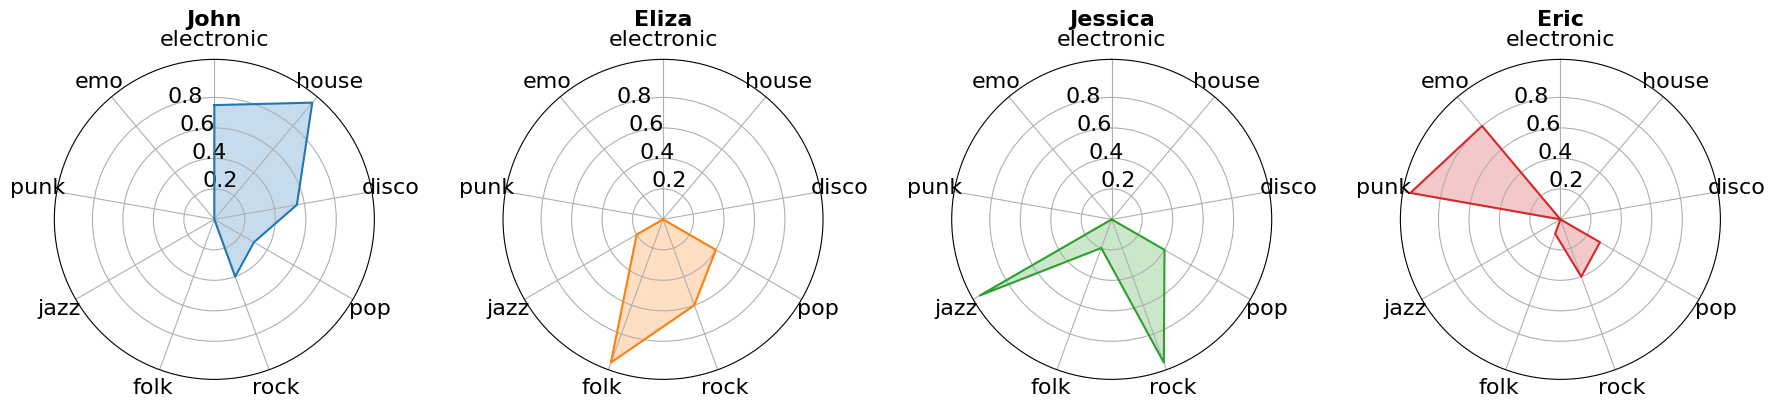

In [3]:
radar.create_users(users, lim=9)

In [4]:
w = widgets.interact(process_song, ind=choose_ind)

interactive(children=(Dropdown(description='Song title: ', options=(('Mi Máquina De Volar by Miguel Mateos - Z…

Can verify classification of music using YouTube links:

In some cases, the NN is able to correctly classify \
Morning Would by Jesse Rose https://www.youtube.com/watch?v=ORbu9Zve_Bc \
The Beat of My Heart by Elaine Elias https://www.youtube.com/watch?v=Nw5w5QuOswg \

In others, the classification is not quite there \
Money Changes Everything by Cyndi Lauper https://www.youtube.com/watch?v=8ffc0TCGIG4 \
Sous la Tour Eiffel by Taboo https://www.youtube.com/watch?v=V6WdlNO0wxc \
Heartbeeps by The Mae Shi https://www.youtube.com/watch?v=aZGXiUllAuU \

## Load and Process Data <a class="anchor" id="data-bullet"></a>

**Summary:**

Training data comes from the Million Song Dataset and is in the form of .h5 files. The data must first be extracted and then processed before training. The extracting and processing were performed by the 'process_h5_to_df.py' and 'process_df_to_npy.py' scripts. The key steps of processing are (1) remove NaNs, (2) standardize the size of temporal data (pitch and timbre), (3) rescale scalars, (4) remove poorly sampled genres, and (5) create one-hot encodings of genre and genre frequency.

This section shows how the size of temporal data was standardized and how poorly sampled genres were removed from the dataset for demonstration purposes. Removing NaNs, rescaling scalars, and one-hot encodings can be found in 'process_df_to_npy.npy'

### Standardizing Size of Temporal Data

In [5]:
import numpy as np
import pandas as pd
import collections
from scipy.interpolate import Akima1DInterpolator

In [6]:
# as an example, loading a subset of data
subset = pd.read_pickle('/media/andy/Samsung_T5/Machine Learning/Music Recommendation/Subset.pkl')

In [7]:
subset.head()

,song_ID,artist_ID,title,artist_name,release,artist_7digitalid,track_7digitalid,analysis_sample_rate,sections_start,segments_pitches,...,energy,loudness,song_hotttnesss,artist_hotttnesss,artist_mbtags,artist_terms,artist_terms_freq,artist_terms_weight,similar_artists,artist_hotttness
0,SOLBHCO12AB018769A,ARIN12F1187FB3E92C,Big Stax/High Volts (Album Version),Grant Geissman,Time Will Tell,341235,5132847,22050,"[0.0, 31.53264, 46.02109, 60.99337, 80.63561, ...","[[0.16, 0.194, 0.538, 1.0, 0.778, 0.556, 0.357...",...,0.0,-9.993,0.0,None,[production music],"[smooth jazz, jazz fusion, instrumental pop, h...","[1.0, 0.8372168485885083, 0.7870977647303522, ...","[1.0, 0.8851412803254898, 0.8639191788780112, ...","[AR2LRXK1187FB593DD, ARC0PQA1187B98B804, ARQQF...",0.317248
1,SOGOQGE12AB0182907,ARVG4OK1187B9B6BD3,Spaceman,The Killers,Hitzone 49,616,6937326,22050,"[0.0, 6.58084, 24.70751, 44.845, 76.81754, 88....","[[1.0, 0.954, 0.509, 0.502, 0.465, 0.457, 0.49...",...,0.0,-6.546,NaN,None,"[rock and indie, united states, alternative ro...","[rock, alternative, rave, disco, new wave, sou...","[1.0, 0.8476018315794605, 0.3707999554207882, ...","[1.0, 0.8889613897444565, 0.6476217325902135, ...","[ARVN9FZ1187FB393F1, AR9O98A1187FB39621, ARYVO...",0.819588
2,SOWTIDJ12AB018808C,ARGCY1Y1187B9A4FA5,Pulecenella 'e mò,Gloriana,Il meglio di Gloriana,266506,8044883,22050,"[0.0, 12.40949, 33.86513, 47.97004, 73.99013, ...","[[0.031, 0.022, 0.056, 0.036, 0.025, 0.016, 0....",...,0.0,-17.522,0.0,None,[],"[teen pop, country rock, country music, female...","[0.9769957203952209, 0.9769957203952209, 0.976...","[1.0, 1.0, 1.0, 0.8484985832840718, 0.82705290...","[AR23BO81187FB47087, ARFJXKQ119B86694AF, ARNHX...",0.477225
3,SONIHLC12AB0187B0C,ARYFROT1187B9B78C2,Iskorosten' (instr.),Butterfly Temple,Za Solntsem Vsled,604768,8968753,22050,"[0.0, 7.85497, 23.85339, 37.18821, 45.62191]","[[0.768, 0.792, 0.867, 0.861, 0.863, 0.988, 0....",...,0.0,-10.777,NaN,None,[],"[doom metal, viking metal, folk metal, death m...","[0.9648610538926313, 0.8538369682764827, 0.873...","[1.0, 0.9838773239907247, 0.9724934211084154, ...","[ARLPWJI1187FB4E7A4, ARBKRXT1187FB55707, AR1UF...",0.366744
4,SOBOFKI12A8C134832,ARK7ZPW1187B99C170,Atto Quarto: 'La Fatal Pietra Sovra Me Si Chiu...,Orchestra e Coro del Palacio de Bellas Artes D...,Verdi: Aida,12255,2158524,22050,"[0.0, 23.47072, 45.39102, 62.21977, 78.45318, ...","[[0.859, 0.803, 0.908, 0.768, 0.822, 0.819, 0....",...,0.0,-21.080,NaN,None,"[greek, european]","[opera, classical, chill-out, bel canto, easy ...","[0.9941491530111347, 1.0, 0.847676065459408, 0...","[1.0, 0.9193998707352394, 0.9057596721902488, ...","[ARSLGYI12454A4287A, ARVZZBC11F50C509EB, ARJMB...",0.360345


Of the 'raw' data, want only 'segments_pitches' 'segments_timbre' 'tempo' 'time_signature' 'key' 'mode' 'loudness' 'artist_terms' and 'artist_terms_freq'

'segments_pitches' and 'segments_timbre' will need to rescaled to a standard length

'tempo' 'time_signature' 'key' 'mode' and 'loudness' need to be scaled using sklearn's `StandardScaler`

'artist_terms' and 'artist_terms_freq' need to be downsampled to only the top 80% of genres and then transformed using one-hot encoding

In [8]:
seg_lens = [len(x) for x in subset['segments_pitches']]

seg_len_hist = collections.Counter(seg_lens)
seg_len_hist = {key: value for key, value in sorted(seg_len_hist.items(), key=lambda x: x[0])}

run_sum = np.zeros([len(seg_len_hist), 2])
run_sum[:,0] = list(seg_len_hist.keys())
run_sum[:,1] = np.cumsum(list(seg_len_hist.values()))
run_sum[:,1] /= run_sum[-1,1]

counts, bins = np.histogram(seg_lens, bins=850)

Text(0, 0.5, 'running sum')

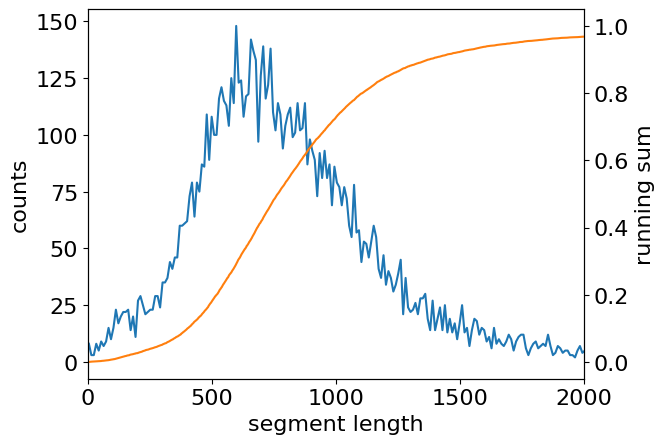

In [9]:
plt.plot(bins[:-1], counts)
plt.grid(False)
plt.xlim([0,2000])
plt.xlabel('segment length')
plt.ylabel('counts')

plt.twinx()
plt.plot(run_sum[:,0], run_sum[:,1], color='C1')

plt.grid(False)
plt.ylabel('running sum')

In [10]:
print('median length: ',np.median(seg_lens))

median length:  766.5


Since median song 'length' is 766.5, setting standard length of song to 1000 and rescaling with interpolation

Text(0.5, 0, 'segment start')

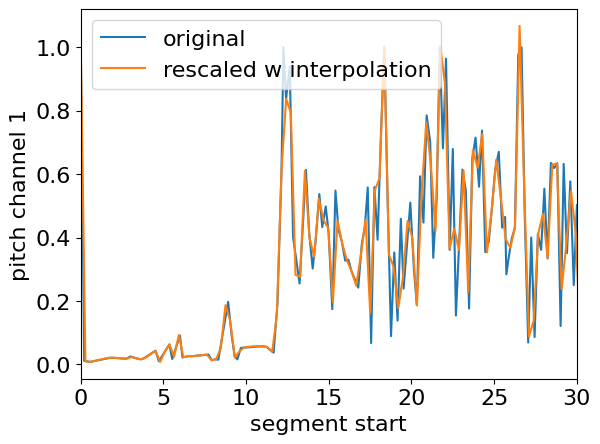

In [11]:
ind = 1
pitch_interp = Akima1DInterpolator(subset['segments_start'][ind], subset['segments_pitches'][ind][:,0])
start, end = subset['segments_start'][ind][0], subset['segments_start'][ind][-1]

N = 1000
plt.plot(subset['segments_start'][ind], subset['segments_pitches'][ind][:,0], label='original')
plt.plot(np.linspace(start, end, N), pitch_interp(np.linspace(start, end, N)), label='rescaled w interpolation')

plt.grid(False)
plt.xlim([0,30])
plt.legend(loc=2)
plt.ylabel('pitch channel 1')
plt.xlabel('segment start')

Interpolation creates signal with minimal loss

### Removing Undersampled Genres (from ~7500 genres to 349)

In [12]:
import numpy as np
import pandas as pd
import collections
import itertools

In [13]:
terms = list(itertools.chain(*subset['artist_terms']))

his = collections.Counter(terms)
his = {key: value for key, value in sorted(his.items(), key=lambda x: -x[1])}

running_sum = np.zeros(len(his))
my_sum = 0
for ind, val in enumerate(his.values()):
    my_sum += val
    running_sum[ind] = my_sum
running_sum /= my_sum

Text(0.5, 0, 'Number of Genres Considered')

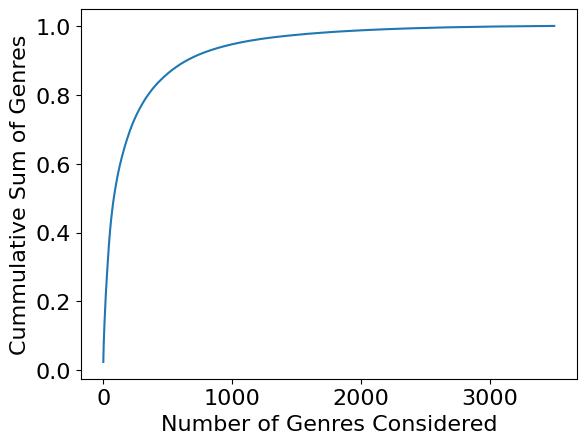

In [14]:
plt.plot(running_sum)

plt.grid(False)
plt.ylabel('Cummulative Sum of Genres')
plt.xlabel('Number of Genres Considered')

In [15]:
df = pd.DataFrame({'terms':his.keys(), 'counts':his.values()})

In [16]:
print(df.iloc[348], running_sum[348]-running_sum[347])
print(df.iloc[649], running_sum[649]-running_sum[647])

terms     experimental rock
counts                  141
Name: 348, dtype: object 0.0005288603996084218
terms     dub techno
counts            54
Name: 649, dtype: object 0.0004050845614022025


In [17]:
print('Fraction of genre mentions: ',running_sum[348])

Fraction of genre mentions:  0.8001170244288496


Of the ~ 3500 genres found in the subset (~7500 in the full dataset), the 349 most frequently mentioned genres encapsulate 80% of the data

To reduce dimensionality of genre dimension, keeping only these 349 most frequently occuring genres

In [18]:
terms_80 = list(df['terms'].iloc[:349])

## Modeling and Training <a class="anchor" id="model-bullet"></a>

**Summary:**

The algorithm is a supervised learning problem where a genre vector, which is generated by taking a one-hot encoding of 'artist_terms' and weighting by 'artist_terms_freq' (see `process_df_to_npy.py`), is learned from pitch, timbre, tempo, time_signature, key, mode, and loudness. Both pitch and timbre are 2D with one temporal dimension and 12 channels. Pitch and timbre are processed using separate 1D convolutional NNs and tempo, time_signature, key, mode, and loudness are processed using a dense, feedforward NN. The three independent networks are then fed into a larger dense, feedforward network that predicts the genre vector. Cosine similarity was chosen for the loss function.

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

from sklearn.model_selection import train_test_split

In [20]:
def cosine_sim(u, v):
    return np.dot(u, v)/(np.sqrt(np.dot(u,u)*np.dot(v,v)))
def rank_ind(u):
    return np.argsort(-u)
def class_accuracy(y, y_pred, N=10, threshold=0.5):
    mask = [i>threshold for i in y]
    limit = sum(mask) if sum(mask)<N else N
    imp_ind = np.argsort(-y)[:N]
    imp_ind_pred = np.argsort(-y_pred)[:N]
    return sum(imp_ind == imp_ind_pred)/N

In [21]:
model = keras.models.load_model('model03/epoch40.model')

2022-11-17 18:54:24.314214: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-17 18:54:24.315109: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-17 18:54:24.315608: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (andy-XPS-13-9360): /proc/driver/nvidia/version does not exist
2022-11-17 18:54:24.318627: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [22]:
# 1,200,000 trainable parameters. Trains a bit more quickly 
input_1 = keras.Input(shape=((1000,12)))
x = layers.Conv1D(filters=48,kernel_size=5,strides=5,padding='same',activation='relu')(input_1)
x = layers.Conv1D(filters=48,kernel_size=5,strides=1,padding='same',activation='relu')(x)
x = layers.MaxPool1D(pool_size=2,padding='same')(x)
x = layers.BatchNormalization()(x)
# 100x48
x = layers.Conv1D(filters=96,kernel_size=5,strides=5,padding='same',activation='relu')(x)
x = layers.Conv1D(filters=96,kernel_size=5,strides=1,padding='same',activation='relu')(x)
x = layers.MaxPool1D(pool_size=2,padding='same')(x)
x = layers.BatchNormalization()(x)
# 10x96
x = layers.Conv1D(filters=192,kernel_size=5,strides=2,padding='same',activation='relu')(x)
x = layers.Conv1D(filters=192,kernel_size=3,strides=1,padding='same',activation='relu')(x)
x = layers.GlobalAveragePooling1D()(x)
# x = layers.BatchNormalization()(x)

input_2 = keras.Input(shape=((1000,12)))
x2 = layers.Conv1D(filters=48,kernel_size=5,strides=5,padding='same',activation='relu')(input_2)
x2 = layers.Conv1D(filters=48,kernel_size=5,strides=1,padding='same',activation='relu')(x2)
x2 = layers.MaxPool1D(pool_size=2,padding='same')(x2)
x2 = layers.BatchNormalization()(x2)
# 100x48
x2 = layers.Conv1D(filters=96,kernel_size=5,strides=5,padding='same',activation='relu')(x2)
x2 = layers.Conv1D(filters=96,kernel_size=5,strides=1,padding='same',activation='relu')(x2)
x2 = layers.MaxPool1D(pool_size=2,padding='same')(x2)
x2 = layers.BatchNormalization()(x2)
# 10x96
x2 = layers.Conv1D(filters=192,kernel_size=5,strides=2,padding='same',activation='relu')(x2)
x2 = layers.Conv1D(filters=192,kernel_size=3,strides=1,padding='same',activation='relu')(x2)
x2 = layers.GlobalAveragePooling1D()(x2)
# x2 = layers.BatchNormalization()(x2)

input_3 = keras.Input(shape=(5,))
x3 = layers.Dense(31,activation='relu')(input_3)
x3 = layers.BatchNormalization()(x3)
x3 = layers.Dense(93,activation='relu')(x3)
# x3 = layers.BatchNormalization()(x3)

z = layers.Concatenate(axis=1)([x, x2, x3])
z = layers.BatchNormalization()(z)
z = layers.Dense(477, activation='relu')(z)
z = layers.BatchNormalization()(z)
z = layers.Dense(477, activation='relu')(z)
z = layers.BatchNormalization()(z)
outputs = layers.Dense(349)(z)

model = keras.Model(inputs=[input_1, input_2, input_3], outputs=outputs, name='full03')
model.summary()

model.compile(
    optimizer='adam',
    loss=keras.losses.CosineSimilarity()
)

Model: "full03"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1000, 12)]   0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1000, 12)]   0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 200, 48)      2928        ['input_1[0][0]']                
                                                                                                  
 conv1d_6 (Conv1D)              (None, 200, 48)      2928        ['input_2[0][0]']                
                                                                                             

                                                                                                  
 dense_4 (Dense)                (None, 349)          166822      ['batch_normalization_7[0][0]']  
                                                                                                  
Total params: 1,206,884
Trainable params: 1,203,384
Non-trainable params: 3,500
__________________________________________________________________________________________________


In [ ]:
root = '/u/scratch/k/kimvonga/MillionSongDataset/npy_from_df/'
dirs = list('ABCDEFGHIJKLMNOPQRSTUVWYXZ')
for epoch in range(0,5):
    for my_dir in dirs:
        path = root+my_dir
        pitch = np.load(path+'pitch.npy'); timbre = np.load(path+'timbre.npy')
        features1D = np.load(path+'features1D.npy'); label = np.load(path+'labels.npy') - 0.2
        
        pitch, _, timbre, _, features1D, _, label, _ = train_test_split(pitch, timbre, features1D, label, random_state=1, test_size=0.01)

        model.fit([pitch, timbre, features1D], label, batch_size=128, validation_split=0.05, workers=4)
    model.save('model03/'+'epoch'+f"{epoch:02d}"+'.model')